### Import Packages

In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch import flatten

### Load Dataset

In [17]:
print(os.getcwd())
print(os.path.join(os.getcwd(), "emotion_dataset", "train"))

c:\Users\osman\OneDrive\Documents\Python Projects\AI_Guild\emotion-classifier-baseline-main
c:\Users\osman\OneDrive\Documents\Python Projects\AI_Guild\emotion-classifier-baseline-main\emotion_dataset\train


In [18]:
# transforms are used to convert your images into more usable data structures such as a tensor, which is basically an array
# of numbers
transformations = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])

# We will need the directories for where we have stored the images so we can load them in with ImageFolder
train_dir = os.path.join(os.getcwd(), "emotion_dataset", "train")
test_dir = os.path.join(os.getcwd(), "emotion_dataset", "test")

# Now we load in our images using image folder
# Note: ImageFolder only works if your files are stored in a certain order so train/classes so examples, train/angry, train/sad, etc.
train_set = datasets.ImageFolder(root=train_dir, transform=transformations)
test_set = datasets.ImageFolder(root=test_dir, transform=transformations)

# Now we use a data loader to make our data iterable
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True,pin_memory=True)

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0823, 0.0745, 0.0588],
          [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0823, 0.0627],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0667, 0.0588],
          ...,
          [0.0000, 0.0196, 0.0000,  ..., 0.0157, 0.0157, 0.0314],
          [0.0118, 0.0000, 0.0118,  ..., 0.1372, 0.0274, 0.0510],
          [0.0157, 0.0078, 0.0000,  ..., 0.0667, 0.0078, 0.0588]]],


        [[[0.4431, 0.4470, 0.4470,  ..., 0.1765, 0.0667, 0.1176],
          [0.4431, 0.4431, 0.4353,  ..., 0.2117, 0.1372, 0.0941],
          [0.4392, 0.4431, 0.4313,  ..., 0.1216, 0.1568, 0.1333],
          ...,
          [0.2510, 0.1294, 0.0745,  ..., 0.0823, 0.0941, 0.1020],
          [0.2588, 0.2039, 0.1451,  ..., 0.0745, 0.0784, 0.0784],
          [0.4196, 0.3843, 0.3137,  ..., 0.0823, 0.0706, 0.0627]]],


        [[[0.5019, 0.5529, 0.6588,  ..., 0.7607, 0.7333, 0.7097],
          [0.4000, 0.4588, 0.6274,  ..., 0.7568, 0.7254, 0.7529],
          [0.3294, 0.3451, 0.4313,  .

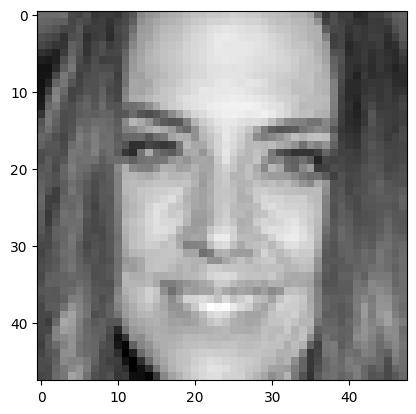

In [19]:
labels = ['angry', 'disgust', 'fear', 'happy','neutral', 'sad', 'surprise']
count = 0
x = []
for i in train_loader:
    x.append(i)
    if count == 10: 
        break;
    count += 1
print(x[1])
plt.imshow(x[0][0][0][0], cmap='gray')

### Create Architecture

In [20]:
class Net(nn.Module): # Our Neural Network class inherents the nn.Module class
    def __init__(self):
        super().__init__()
        # First 2d convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1) # --> 46*46*32
        self.relu1 = nn.ReLU()
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2) # 23*23*32
        
        # Second 2d convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1) # --> 21*21*64
        self.relu2 = nn.ReLU()
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2) # 10*10*64
        
        # Third 2d convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1) # --> 8*8*128
        self.relu3 = nn.ReLU()
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2) # 4*4*128 = 2048
        
        # Fully connected layers

        self.fc1 = nn.Linear(2048, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 7)


    def foward(self, x): # Performs foward propagation
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.max3(x)

        x = flatten(x, 1) # convert from 2-d to 1-d
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x


### Train

In [30]:
def train(model: Net, optimizer, loss_function,device):
    model.train() # tells python that the model is training

    for idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # clear our gradients
        optimizer.zero_grad()
        # foward pass
        output = model.foward(images)
        # calculate loss
        loss = loss_function(output, labels)
        # calculate the gradients
        loss.backward() # just calculates the gradients
        optimizer.step() # updates the parameters
        if idx % 25 == 0:
            print(f"loss = {loss}")


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 1

for epoch in range(epochs):
    train(model=model, optimizer=optimizer, loss_function=loss_function, device=device)
    test(model=model, device=device, test_loader=test_set)

loss = 1.953257441520691
loss = 1.7371035814285278
loss = 1.7945306301116943
loss = 1.7403911352157593
loss = 1.8002928495407104
loss = 1.696860432624817
loss = 1.7773370742797852
loss = 2.0518102645874023
loss = 1.785746455192566
loss = 1.7944859266281128
loss = 1.8736984729766846
loss = 1.678945541381836
loss = 1.6092793941497803
loss = 1.7308881282806396
loss = 1.4821614027023315
loss = 1.7512495517730713
loss = 1.6416887044906616
loss = 1.8118634223937988
loss = 1.625670313835144
loss = 1.7722015380859375
loss = 1.4986680746078491
loss = 1.624344825744629
loss = 1.5231481790542603
loss = 1.759404182434082
loss = 1.4528580904006958
loss = 1.3716238737106323
loss = 1.7140169143676758
loss = 1.4968160390853882
loss = 1.4899828433990479
loss = 1.3849570751190186
loss = 1.5013267993927002
loss = 1.6895908117294312
loss = 1.5553853511810303
loss = 1.5261098146438599
loss = 1.415335774421692
loss = 1.625714898109436
